In [3]:
%pip install setuptools

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install pymc

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [6]:

# Load and preprocess data
df = pd.read_csv('../data/brent_oil_prices.csv')

df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True, errors='coerce')

df = df[(df['Date'] >= '2012-01-01') & (df['Date'] <= '2022-09-30')]
df['Price'] = df['Price'].interpolate()
data = df['Price'].values  # Use raw prices (or replace with df['Log_Returns'] for volatility)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


c:\Users\Belete\AppData\Local\Programs\Python\Python313\Lib\site-packages\rich\live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 368 seconds.
There were 345 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau    21.301  20.912   0.000   73.000      2.039    2.237     159.0   
mu_1   54.639   4.118  47.741   62.660      0.248    0.121     250.0   
mu_2   48.402   1.279  46.070   50.758      0.071    0.076     413.0   
sigma   9.425   0.683   8.152   10.673      0.014    0.010    2517.0   

       ess_tail  r_hat  
tau       218.0   1.02  
mu_1      505.0   1.01  
mu_2      230.0   1.01  
sigma    3742.0   1.00  


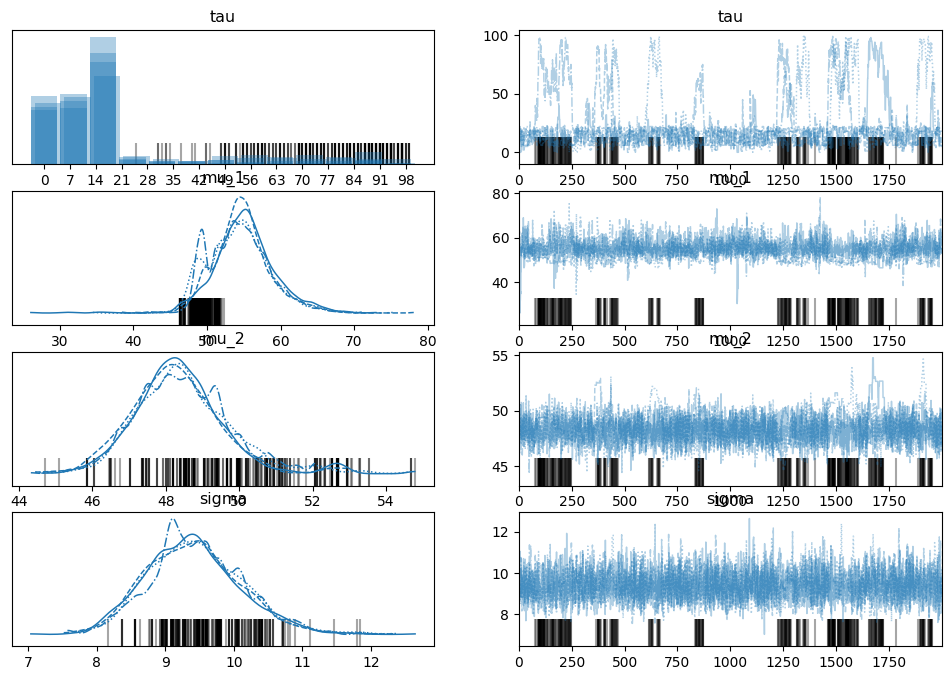

<Figure size 1000x600 with 0 Axes>

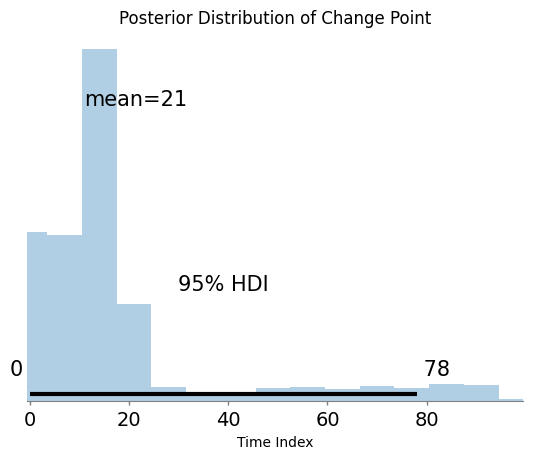

In [7]:

# Generate example data
data = np.random.normal(50, 10, 100)  # Example data for demonstration

with pm.Model() as model:
    # Prior for switch point (tau)
    n_points = len(data)
    tau = pm.DiscreteUniform('tau', lower=0, upper=n_points-1)
    
    # Priors for means before and after change point
    mu_1 = pm.Normal('mu_1', mu=50, sigma=20)
    mu_2 = pm.Normal('mu_2', mu=50, sigma=20)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Switch function for mean
    idx = np.arange(n_points)
    mu = pm.math.switch(tau > idx, mu_1, mu_2)
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=data)
    
    # MCMC sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)  # Changed to True

# Check convergence
print(az.summary(trace))

# Plot trace
az.plot_trace(trace)
plt.show()

# Plot posterior of tau
plt.figure(figsize=(10, 6))
az.plot_posterior(trace, var_names=['tau'], kind='hist', hdi_prob=0.95)
plt.xlabel('Time Index')
plt.title('Posterior Distribution of Change Point')
plt.show()

Most likely change point: 2023-01-22 00:00:00
Probability of price increase: 9.75%
Estimated price change: -11.41%


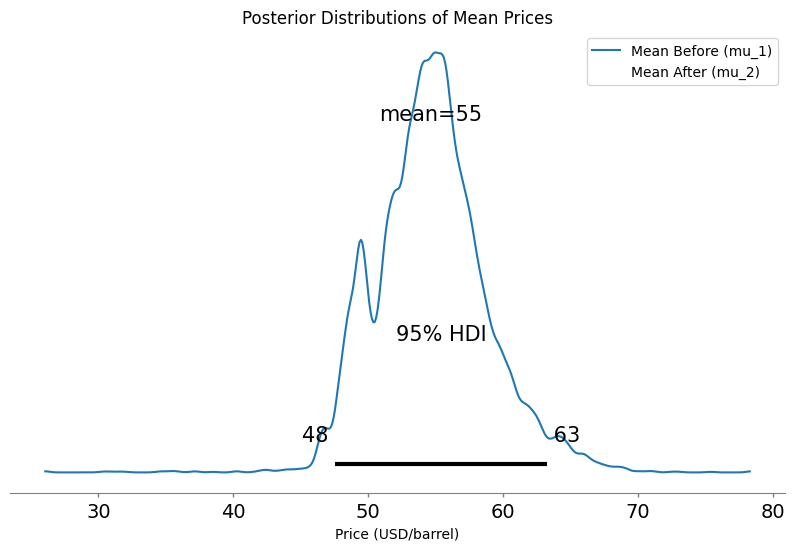

In [9]:

# Example DataFrame (replace with your actual data)
# Assuming data has 'Date' and 'Price' columns
dates = pd.date_range(start='2023-01-01', periods=100, freq='D')
prices = np.random.normal(50, 10, 100)  # Replace with df['Price']
df = pd.DataFrame({'Date': dates, 'Price': prices})

# Assuming trace is from the previous model with return_inferencedata=True
# Extract samples from InferenceData object
tau_samples = trace.posterior['tau'].values.flatten()  # Flatten to 1D array
mu_1_samples = trace.posterior['mu_1'].values.flatten()
mu_2_samples = trace.posterior['mu_2'].values.flatten()

# Convert tau to date
tau_mean = int(np.mean(tau_samples))
change_point_date = df['Date'].iloc[tau_mean]
print(f'Most likely change point: {change_point_date}')

# Compare means
mean_diff = mu_2_samples - mu_1_samples
prob_increase = np.mean(mean_diff > 0)
percent_change = (np.mean(mu_2_samples) - np.mean(mu_1_samples)) / np.mean(mu_1_samples) * 100
print(f'Probability of price increase: {prob_increase:.2%}')
print(f'Estimated price change: {percent_change:.2f}%')

# Plot posterior distributions of means
plt.figure(figsize=(10, 6))
az.plot_posterior(
    trace,
    var_names=['mu_1', 'mu_2'],
    kind='kde',
    point_estimate='mean',
    hdi_prob=0.95,
    ref_val=None,
    ax=plt.gca()
)
plt.xlabel('Price (USD/barrel)')
plt.title('Posterior Distributions of Mean Prices')
plt.legend(['Mean Before (mu_1)', 'Mean After (mu_2)'])
plt.show()